In [4]:
# %load_ext autoreload
# %autoreload 2


# Imports

In [1]:
# Standard library
import os
import sys
import time
import math
import io
import json
import ast
import random
from datetime import datetime
from collections import Counter
from typing import List, Dict, Any

# Third-party libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
from torch.utils.data import DataLoader, Dataset, TensorDataset
import editdistance
import Levenshtein
import tqdm
import fire
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from wordcloud import WordCloud

# Random Baselines

In [2]:
import pandas as pd
import torch
import json
import ast
import numpy as np
import random
import editdistance

def evaluate_random_baseline(test_dataset_path, vocab_all_path, n_samples, verbose_generated, use_activity_distribution, stop_at_eos, seed=42):

    def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)

    set_seed(seed)
    # Load test set
    test_data_df = pd.read_csv(test_dataset_path)
    test_data_df['activities'] = test_data_df['activities'].apply(ast.literal_eval)
    print(test_data_df['activities'][0])

    # Load vocab
    with open(f'{vocab_all_path}.json', 'r') as f:
        vocab_all = json.load(f)
        vocab_all = {str(k): int(v) for k, v in vocab_all.items()}  # enforce proper types
    print(vocab_all)
    idx2label = {v: k for k, v in vocab_all.items()}
    eos_token_id = vocab_all.get('<EOS>')
    unk_token_id = vocab_all.get('<UNK>')

    # Encode activities
    encoded_data = []
    bounds_test = []
    current_index = 0
    for acts in test_data_df['activities']:
        encoded_case = [vocab_all.get(act, unk_token_id) for act in acts]
        encoded_data.extend(encoded_case)
        bounds_test.append((current_index, current_index + len(encoded_case) - 1))
        current_index += len(encoded_case)

    data_test = torch.tensor(encoded_data, dtype=torch.long)

    # Extract activity IDs used in the test set (excluding special tokens)
    unique_ids_in_test = set(data_test.tolist())
    activity_ids = sorted(list(unique_ids_in_test - {'<PAD>', '<MASK>'}))

    # Optionally use frequency distribution from test set
    if use_activity_distribution:
        unique, counts = torch.unique(data_test, return_counts=True)
        freq = dict(zip(unique.tolist(), counts.tolist()))
        print("freq", freq)
        activity_probs = [freq.get(tok, 0) for tok in activity_ids]
        total = sum(activity_probs)
        activity_weights = [f / total for f in activity_probs]
    else:
        activity_weights = None

    # Random prediction and evaluation
    edit_similarities_all = []
    verbose_count = 0

    for _ in range(n_samples):
        prefix_start, suffix_end = random.choice(bounds_test)
        if suffix_end - prefix_start < 2:
            continue

        suffix_start_random = random.randint(prefix_start + 1, suffix_end - 1) # todo at least 2
        prefix_indices = data_test[prefix_start:suffix_start_random]
        true_suffix_indices = data_test[suffix_start_random:suffix_end + 1].tolist()

        if stop_at_eos:
            pred_suffix = random.choices(activity_ids, weights=activity_weights, k=512) # todo max length
            # Remove <EOS> and everything after it
            if eos_token_id in pred_suffix:
                eos_idx = pred_suffix.index(eos_token_id)
                pred_suffix = pred_suffix[:eos_idx]
            if eos_token_id in true_suffix_indices:
                eos_idx = true_suffix_indices.index(eos_token_id)
                true_suffix_indices = true_suffix_indices[:eos_idx]
        else:
            pred_suffix = random.choices(activity_ids, weights=activity_weights, k=len(true_suffix_indices))

        prefix = [idx2label.get(tok.item(), "<UNK>") for tok in prefix_indices]
        true_suffix = [idx2label.get(tok, "<UNK>") for tok in true_suffix_indices]
        suffix = [idx2label.get(tok, "<UNK>") for tok in pred_suffix]


        if verbose_count < verbose_generated:
            print(f'\nPREFIX             :\t{len(prefix_indices)} tokens\t{prefix_indices.tolist()}')
            print(f'TRUE_SUFFIX        :\t{len(true_suffix_indices)} tokens\t{true_suffix_indices}')
            print(f'PREDICTED_SUFFIX   :\t{len(pred_suffix)} tokens\t{pred_suffix}')

            print(f'PREFIX             :\t{len(prefix)} tokens\t{prefix}')
            print(f'TRUE_SUFFIX        :\t{len(true_suffix)} tokens\t{true_suffix}')
            print(f'PREDICTED_SUFFIX   :\t{len(suffix)} tokens\t{suffix}')

            verbose_count += 1

        edit_dist = editdistance.eval(pred_suffix, true_suffix_indices)
        if max(len(pred_suffix), len(true_suffix_indices)) == 0:
            edit_similarity = 1
        else:
            norm_dist = edit_dist / max(len(pred_suffix), len(true_suffix_indices))
            edit_similarity = 1 - norm_dist
        edit_similarities_all.append(edit_similarity)

        if verbose_count <= verbose_generated:
            print(f'\tEdit distance:\t{edit_dist}\tsimilarity score:\t{edit_similarity*100:.2f}%')

    # Summary statistics
    edit_similarities_all = np.array(edit_similarities_all)
    mean_score = edit_similarities_all.mean()
    std_score = edit_similarities_all.std(ddof=1)
    ci95 = 1.96 * std_score / np.sqrt(len(edit_similarities_all))

    print(f"\nMean Edit Similarity: {mean_score:.4f}") # todo DLS
    print(f"Std Deviation       : {std_score:.4f}")
    print(f"95% Confidence Int. : ±{ci95:.4f}")

    # return {
    #     "mean": mean_score,
    #     "std": std_score,
    #     "ci95": ci95,
    #     "edit_similarities_all": edit_similarities_all.tolist()
    # }


In [4]:
evaluate_random_baseline(
    test_dataset_path="data_processed/SynthBest_2_test.csv",
    vocab_all_path="data_processed/vocab_synthetic",
    n_samples=1000,
    verbose_generated=10,
    use_activity_distribution=False,
    stop_at_eos=True,
    seed=42
)

['k', 'f', 'v', 'l', 'e', 'n', 'k', 't', 't', 'h', 'e', '<EOS>']
{'<EOS>': 0, '<PAD>': 1, '<UNK>': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}

PREFIX             :	1 tokens	[3]
TRUE_SUFFIX        :	13 tokens	[6, 19, 21, 21, 8, 21, 17, 23, 3, 23, 9, 18, 21]
PREDICTED_SUFFIX   :	7 tokens	[22, 8, 5, 4, 21, 16, 17]
PREFIX             :	1 tokens	['a']
TRUE_SUFFIX        :	13 tokens	['d', 'q', 's', 's', 'f', 's', 'o', 'u', 'a', 'u', 'g', 'p', 's']
PREDICTED_SUFFIX   :	7 tokens	['t', 'f', 'c', 'b', 's', 'n', 'o']
	Edit distance:	12	similarity score:	7.69%

PREFIX             :	13 tokens	[15, 3, 8, 11, 6, 12, 5, 20, 11, 17, 12, 5, 20]
TRUE_SUFFIX        :	1 tokens	[6]
PREDICTED_SUFFIX   :	11 tokens	[27, 13, 24, 14, 22, 3, 27, 8, 3, 27, 3]
PREFIX             :	13 tokens	['m', 'a', 'f', 'i', 'd', 'j', 'c', 'r', 

# Chat GPT

In [6]:
import pandas as pd
import numpy as np
import ast
from scipy import stats
import pandas as pd
import ast  # For safely converting stringified lists
import editdistance

# Load data
df = pd.read_csv("evaluation/gpt_prediction.csv")

# Function to compute Damerau-Levenshtein distance and similarity on token level
def compute_dl_and_similarity(true_str, pred_str):
    try:
        # Convert from string to list of tokens
        true = ast.literal_eval(true_str) if isinstance(true_str, str) else []
        pred = ast.literal_eval(pred_str) if isinstance(pred_str, str) else []

        dist = editdistance.eval(true, pred)  # List-based DL
        max_len = max(len(true), len(pred))
        similarity = 1 - dist / max_len if max_len > 0 else 1.0
        return dist, similarity
    except Exception as e:
        return None, None

# Apply to DataFrame
df[["DL Distance", "DL Similarity"]] = df.apply(
    lambda row: pd.Series(compute_dl_and_similarity(row["True Suffix"], row["Predicted Suffix"])),
    axis=1
)

# Save results
csv_path = "evaluation/gpt_prediction_DL.csv"
df.to_csv(csv_path, index=False)

# Output summary
print(f"Saved to: {csv_path}")
print(df[["DL Distance", "DL Similarity"]].describe())

# Compute summary statistics
mean_sim = df["DL Similarity"].mean()
std_sim = df["DL Similarity"].std()
n = df["DL Similarity"].count()
confidence_interval = stats.t.interval(0.95, df=n-1, loc=mean_sim, scale=std_sim / np.sqrt(n))

print("Mean Similarity", mean_sim)
print("Standard Deviation", std_sim)
print("95% Confidence Interval", confidence_interval)

df

Saved to: evaluation/gpt_prediction_DL.csv
       DL Distance  DL Similarity
count   100.000000     100.000000
mean      1.690000       0.237500
std       0.630776       0.247596
min       1.000000       0.000000
25%       1.000000       0.000000
50%       2.000000       0.333333
75%       2.000000       0.333333
max       4.000000       0.750000
Mean Similarity 0.23750000000000004
Standard Deviation 0.24759647078599284
95% Confidence Interval (0.1883714885532709, 0.2866285114467292)


,Sample,Prefix Lenght,Prefix,True Suffix,True Suffix Lenght,Predicted Suffix,DL Distance,DL Similarity
0,1,1,['assign_seriousness'],"['take_in_charge_ticket', 'resolve_ticket', 'c...",3,"['take_in_charge_ticket', 'wait', 'resolve_tic...",2.0,0.333333
1,2,1,['assign_seriousness'],"['take_in_charge_ticket', 'resolve_ticket', 'c...",3,"['take_in_charge_ticket', 'wait', 'resolve_tic...",2.0,0.333333
2,3,1,['assign_seriousness'],"['take_in_charge_ticket', 'resolve_ticket', 'c...",3,"['take_in_charge_ticket', 'wait', 'resolve_tic...",2.0,0.333333
3,4,3,"['assign_seriousness', 'take_in_charge_ticket'...",['closed'],1,['resolved'],1.0,0.000000
4,5,1,['assign_seriousness'],"['take_in_charge_ticket', 'wait', 'resolve_tic...",4,"['take_in_charge_ticket', 'wait', 'resolve_tic...",1.0,0.750000
...,...,...,...,...,...,...,...,...
95,96,3,"['assign_seriousness', 'take_in_charge_ticket'...",['closed'],1,['resolved'],1.0,0.000000
96,97,2,"['assign_seriousness', 'take_in_charge_ticket']","['wait', 'take_in_charge_ticket', 'resolve_tic...",4,"['wait', 'resolve_ticket', 'resolved', 'closed']",2.0,0.500000
97,98,1,['assign_seriousness'],"['take_in_charge_ticket', 'wait', 'take_in_cha...",5,"['take_in_charge_ticket', 'wait', 'resolve_tic...",2.0,0.600000
98,99,1,['assign_seriousness'],"['take_in_charge_ticket', 'resolve_ticket', 'c...",3,"['take_in_charge_ticket', 'wait', 'resolve_tic...",2.0,0.333333


# Clusters

In [3]:
## Plot parameters
orange = "#ED7D31"
# orange_light = "red"
orange_light = "#F19E65"
blue = "#0070C0"
blue_light = "#8EBAE2"
green = "#70AD47"
grey = "#BFBFBF"

scale=1

font_logs = 8 * scale
font_ticks = 7 * scale

bar_width = 0.2# * scale
alpha = 1

C:\Users\ebelk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ebelk\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\ebelk\AppData\Local\Temp\ipykernel_10360\3404320361.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


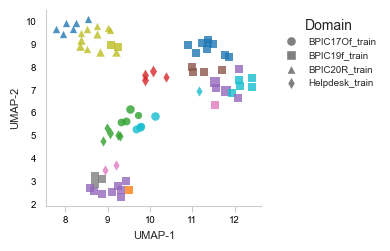

In [4]:
import pandas as pd
import numpy as np
import ast
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

scale = 0.9

# --- IMPORTANT RC PARAMS SETTINGS ---
# These settings will override any conflicting settings from the loaded style
# to ensure your desired tick behavior.
plt.rcParams['xtick.bottom'] = True        # Ensure bottom ticks are enabled
plt.rcParams['xtick.top'] = False          # <--- Set to False for no top ticks
plt.rcParams['xtick.major.size'] = 4       # Explicitly set major tick length
plt.rcParams['xtick.minor.size'] = 2       # Explicitly set minor tick length (optional, can be 0 if not needed)
plt.rcParams['xtick.major.width'] = 0.8    # Explicitly set major tick width
plt.rcParams['xtick.minor.width'] = 0.6    # Explicitly set minor tick width (optional)
plt.rcParams['xtick.direction'] = 'out'    # Ensure ticks point outwards

# Set tick color to match the axis edge color
axis_color = plt.rcParams['axes.edgecolor']
plt.rcParams['xtick.color'] = axis_color   # Set tick color to axis color


# === Load all event logs ===
log_names = ['BPIC17Of_train', 'BPIC19f_train', 'BPIC20R_train', 'Helpdesk_train']
DIR_PROCESSED = 'data_processed'
all_activities = []

for log_name in log_names:
    df_log = pd.read_csv(f'{DIR_PROCESSED}/{log_name}.csv')
    df_log['activities'] = df_log['activities'].apply(ast.literal_eval)

    activity_counts = {}
    for acts in df_log['activities']:
        for act in acts:
            if act == '<EOS>':
                continue
            activity_counts[act] = activity_counts.get(act, 0) + 1

    df_acts = pd.DataFrame(list(activity_counts.items()), columns=['activity_name', 'count'])
    df_acts['event_log'] = log_name
    all_activities.append(df_acts)

df = pd.concat(all_activities, ignore_index=True)

# Optional: remove duplicates
df = df.groupby(['activity_name', 'event_log']).agg({'count': 'sum'}).reset_index()

# Normalize count column
scaler = MinMaxScaler(feature_range=(30, 50))
df['count_normalized'] = scaler.fit_transform(df[['count']])

# === Encode activity names ===
model = SentenceTransformer('all-MiniLM-L6-v2')
activity_embeddings = model.encode(df['activity_name'].tolist(), normalize_embeddings=True)

# === Cluster ===
n_clusters = 16
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(activity_embeddings)

# === UMAP projection ===
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(activity_embeddings)
df['x'] = embedding_2d[:, 0]
df['y'] = embedding_2d[:, 1]

# === Plot ===
symbols = {'BPIC17Of_train': 'o', 'BPIC19f_train': 's', 'BPIC20R_train': '^', 'Helpdesk_train': 'd'}
colors = plt.cm.get_cmap('tab10', n_clusters)

fig, ax = plt.subplots(figsize=(4.5*scale, 2.9*scale))
for _, row in df.iterrows():
    ax.scatter(
        row['x'], row['y'],
        marker=symbols[row['event_log']],
        color=colors(row['cluster']),
        s=row['count_normalized']*scale,
        alpha=0.8,
        edgecolors='k',
        linewidths=0
    )

# Legend
legend_elements = [
    Line2D([0], [0], marker=s, color='w', label=name,
           markerfacecolor='gray', markersize=8*scale)
    for name, s in symbols.items()
]
ax.legend(
    handles=legend_elements,
    title="Domain",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=font_ticks,
    frameon=False
)

# Labels and ticks
ax.set_xlabel("UMAP-1", fontsize=font_logs)
ax.set_ylabel("UMAP-2", fontsize=font_logs)
ax.tick_params(axis='both', labelsize=font_ticks, labelcolor="black")

# Remove unwanted spines
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Ensure grid is OFF
ax.grid(False)

plt.tight_layout()

# Save figure
path_and_name = "figures/results_clusters"
fig.savefig(f'{path_and_name}.svg', format="svg")
fig.savefig(f'{path_and_name}.eps', format="eps")


# END